In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc
import dask
import scipy
import glob
from tqdm import tqdm
from datetime import datetime, timedelta
import netCDF4 as nc
from netCDF4 import Dataset
import geopandas as gpd
import os
import skimage

import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.img_tiles import Stamen
from cartopy.io.img_tiles import MapboxTiles
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings("ignore")

import imageio
import geojson
import requests

from scipy.optimize import curve_fit
import matplotlib as mpl
from matplotlib import font_manager as fm

%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /home/jpalmo/.conda/envs/earthdata/share/proj failed


In [2]:
# 1) Register your new fonts explicitly
font_dir = os.path.expanduser("~/.local/share/fonts")
for path in glob.glob(os.path.join(font_dir, "lm*.otf")):
    fm.fontManager.addfont(path)
for path in glob.glob(os.path.join(font_dir, "cmu*.otf")):
    fm.fontManager.addfont(path)
# Global LaTeX-y defaults
mpl.rcParams.update({
    "text.usetex": False,              # keep mathtext (no TeX required)
    "mathtext.fontset": "cm",          # Computer Modern math
    "axes.unicode_minus": False,

    # Default family = serif (like LaTeX)
    "font.family": "serif",

    # Families mapped to your installed fonts (with sensible fallbacks)
    "font.serif": ["LMRoman10", "CMU Serif", "DejaVu Serif"],
    "font.sans-serif": ["LMSans10", "CMU Sans Serif", "DejaVu Sans"],
    "font.monospace": ["LMMono10", "CMU Typewriter Text", "DejaVu Sans Mono"],
})


### Load Data

In [3]:
initial_detections_df = pd.read_csv('data/initial_detections.csv',)
initial_detections_df['timestamp'] = pd.to_datetime(initial_detections_df['Launch_JD'], unit='D', origin='julian')

In [4]:
grouped = initial_detections_df.groupby('LV_Type')

In [5]:
bar_df = pd.DataFrame({
    'Count': grouped['ime_at_t0'].count(),
    'ime': grouped['ime_at_t0'].mean(),
    'ime_min': grouped['ime_at_t0'].min(),
    'ime_max': grouped['ime_at_t0'].max(),
    # 'ime': grouped['ime'].mean(),
    # 'ime_min': grouped['ime'].min(),
    # 'ime_max': grouped['ime'].max(),
    'Launch_Mass': grouped['Launch_Mass'].mean()
}).round(2)

In [6]:
bar_df.sort_values('ime', ascending=False, inplace=True)

# Figure 2

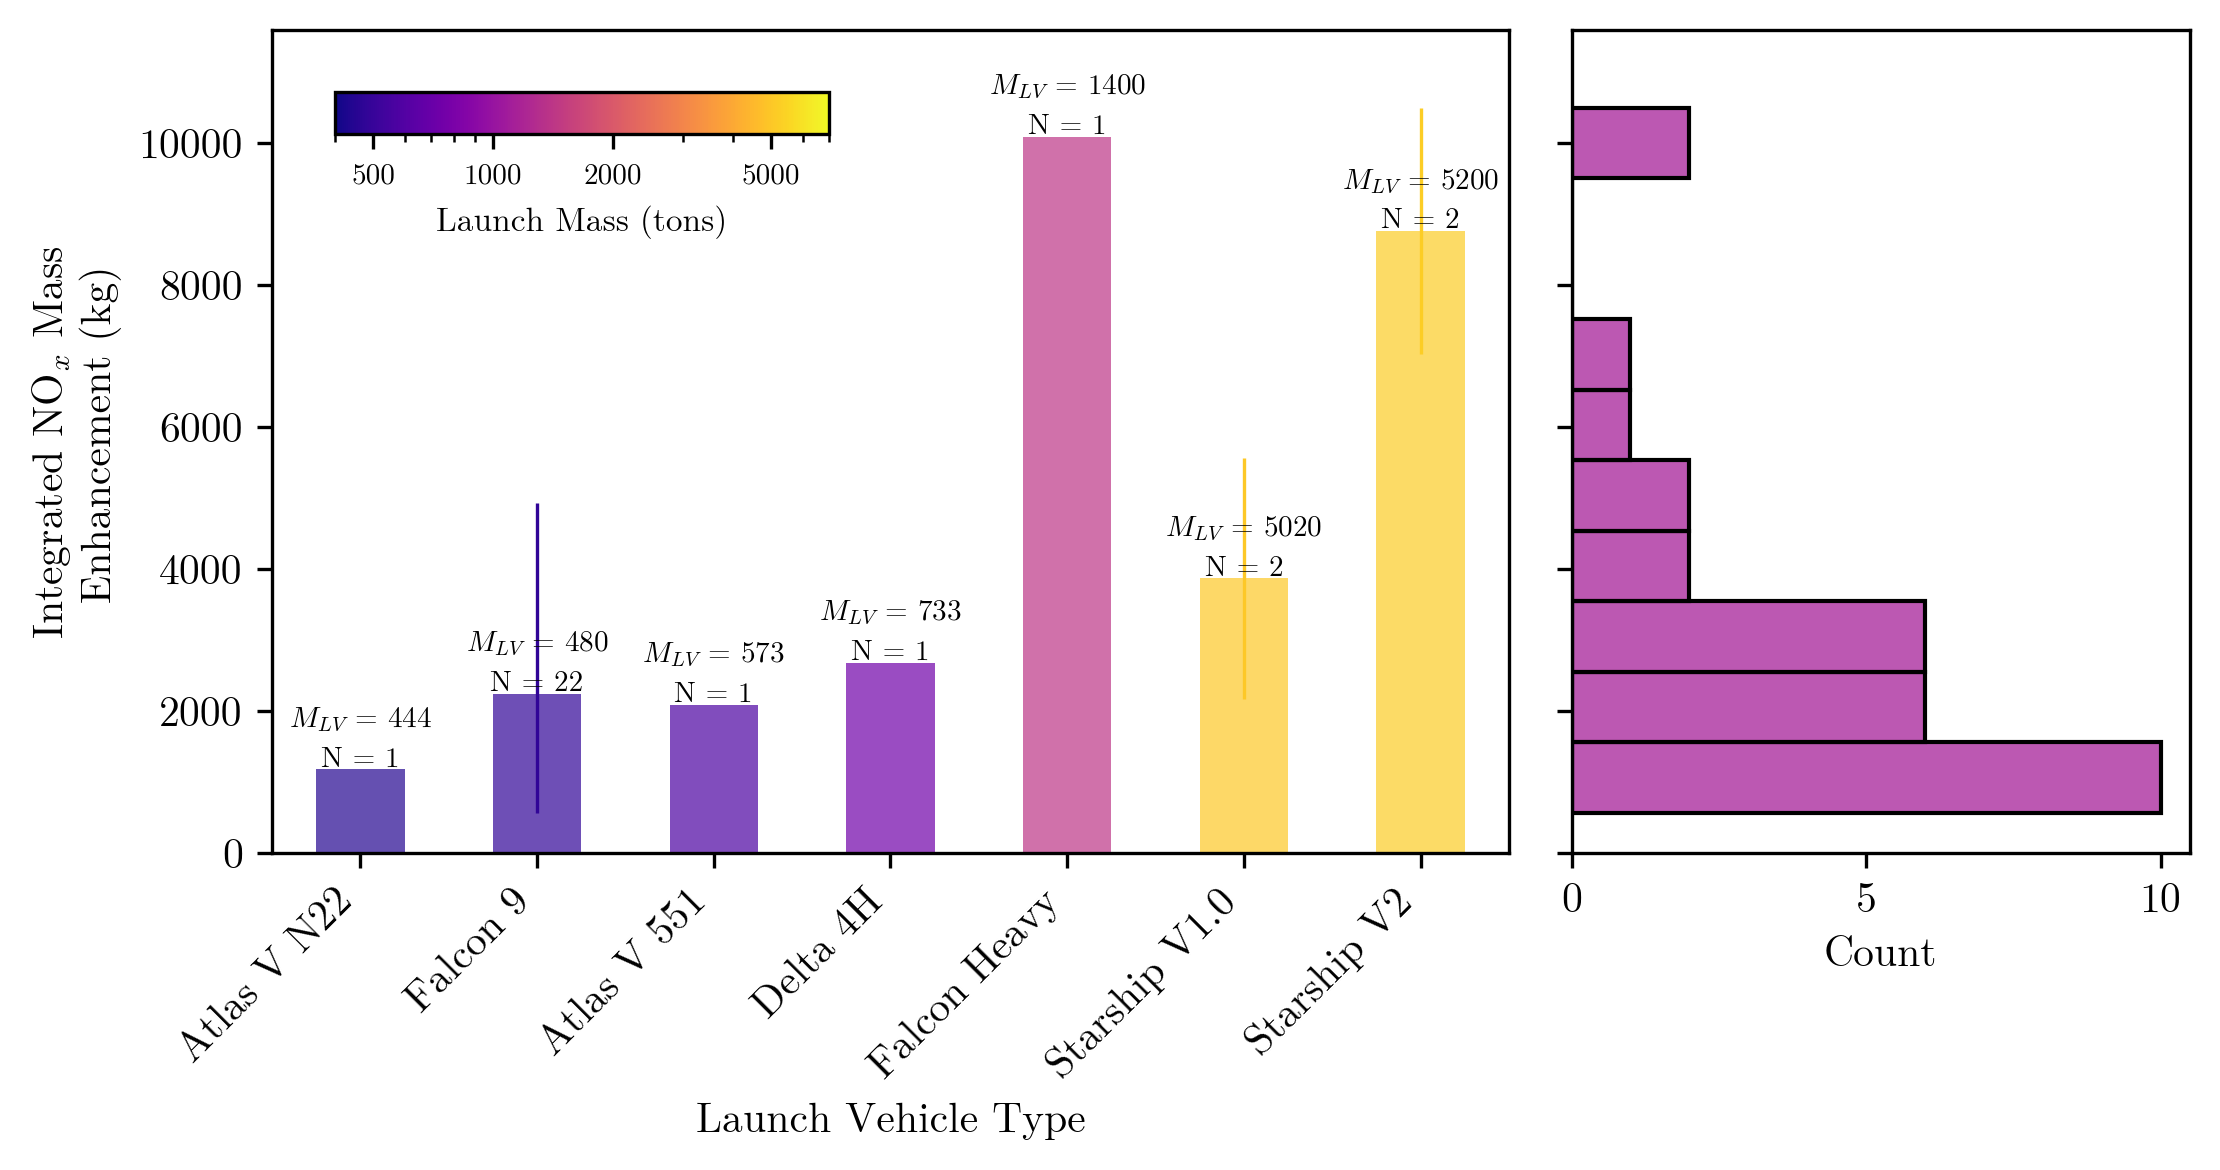

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
import matplotlib.ticker as ticker

# Sort however you want (optional)
bar_sorted = bar_df.sort_values("Launch_Mass")
# bar_sorted = bar_df.sort_values('ime', ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(7.5,4), dpi=300, sharey=True,
                        gridspec_kw={'width_ratios': [2, 1]})

norm = plt.Normalize(np.log10(bar_sorted['ime'].min()), 
                     np.log10(bar_sorted['ime'].max()+1000))
# Use a logarithmic normalization directly on Launch_Mass
log_norm = mpl.colors.LogNorm(
    # vmin=bar_sorted['Launch_Mass'].min(),
    # vmax=bar_sorted['Launch_Mass'].max()+2000
    vmin=400,
    vmax=7000,
    clip=True
)
colors = plt.cm.plasma(log_norm((bar_sorted['Launch_Mass'])))

# Bar plot with colors
# bars = axs[0].bar(range(len(bar_sorted)), bar_sorted['ime'], 
#                   color=colors, alpha=0.75)
# bar plot of IME split by LV_Type
bar_sorted['ime'].plot(kind='bar', ax=axs[0], color=colors, alpha=0.7)

# Add error bars for min-max range
# tmp = bar_sorted#[bar_sorted['Count'] > 1]
# yerr_lower = tmp['ime'] - tmp['ime_min']
# yerr_upper = tmp['ime_max'] - tmp['ime']
# axs[0].errorbar(tmp.index, tmp['ime'], 
#                 yerr=[yerr_lower, yerr_upper], 
#                 fmt='none', ecolor=colors, elinewidth=0.8, capsize=2)

# Add labels for N
for i, (lv, r) in enumerate(bar_sorted.iterrows()):
    axs[0].text(i, r['ime'] + 40, f"N = {int(r['Count'])}", 
                ha='center', fontsize=7)
    
    axs[0].text(i, r['ime'] + 600, r'$M_{LV}$'+f" = {int(r['Launch_Mass'])}", 
                ha='center', fontsize=7)
    
    axs[0].errorbar(i, r['ime'],
                yerr=[[r['ime'] - r['ime_min']], [r['ime_max'] - r['ime']]],
                fmt='none',
                ecolor=colors[i],
                elinewidth=0.8,
                capsize=0)

# Histogram on right panel
sns.histplot(y=initial_detections_df['ime_at_t0'], ax=axs[1], kde=False, bins=10,
             color=plt.cm.plasma(norm(np.log10(bar_sorted['ime'].quantile(0.5)))))
# sns.histplot(y=initial_detections_df['ime'], ax=axs[1], kde=False, bins=10,
#              color=plt.cm.plasma(norm(np.log10(bar_sorted['ime'].quantile(0.5)))))

axs[0].set_ylabel('Integrated NO$_x$ Mass \n Enhancement (kg)')
axs[0].set_xlabel('Launch Vehicle Type')
axs[0].set_xticks(range(len(bar_sorted)))
axs[0].set_xticklabels(bar_sorted.index, rotation=45, ha='right')
axs[0].set_ylim(0, bar_sorted['ime'].max() + 1500)

# # Define scalar mappable for colorbar
# sm = mpl.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
# sm.set_array([])

# # Create inset axes inside axs[0]
# cax = inset_axes(axs[0], 
#                  width="40%",   # width relative to axs[0]
#                  height="5%", # height relative to axs[0]
#                  loc='upper left',
#                  borderpad=1.5)

# # Add colorbar
# cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
# cbar.set_label("Launch Mass (tons)", fontsize=8)
# cbar.ax.tick_params(labelsize=7)

sm = mpl.cm.ScalarMappable(cmap=plt.cm.plasma, norm=log_norm)
sm.set_array([])

# Inset colorbar inside axs[0]
cax = inset_axes(axs[0], 
                 width="40%",   # width relative to axs[0]
                 height="5%", # height relative to axs[0]
                 loc='upper left',
                 borderpad=1.5)

# Add colorbar with log ticks formatted as 10^x
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label("Launch Mass (tons)", fontsize=8)
cbar.ax.tick_params(labelsize=7)
# cbar.ax.xaxis.set_major_formatter(
#     ticker.LogFormatterMathtext()   # formats ticks as 10^x
# )
# Explicitly set ticks and labels
cbar.set_ticks([ 500, 1000, 2000, 5000,])
cbar.set_ticklabels([ 500, 1000, 2000, 5000])

fig.tight_layout()
# save figure
plt.savefig(f'figures/fig_2.png', dpi=300)


# Figure S6

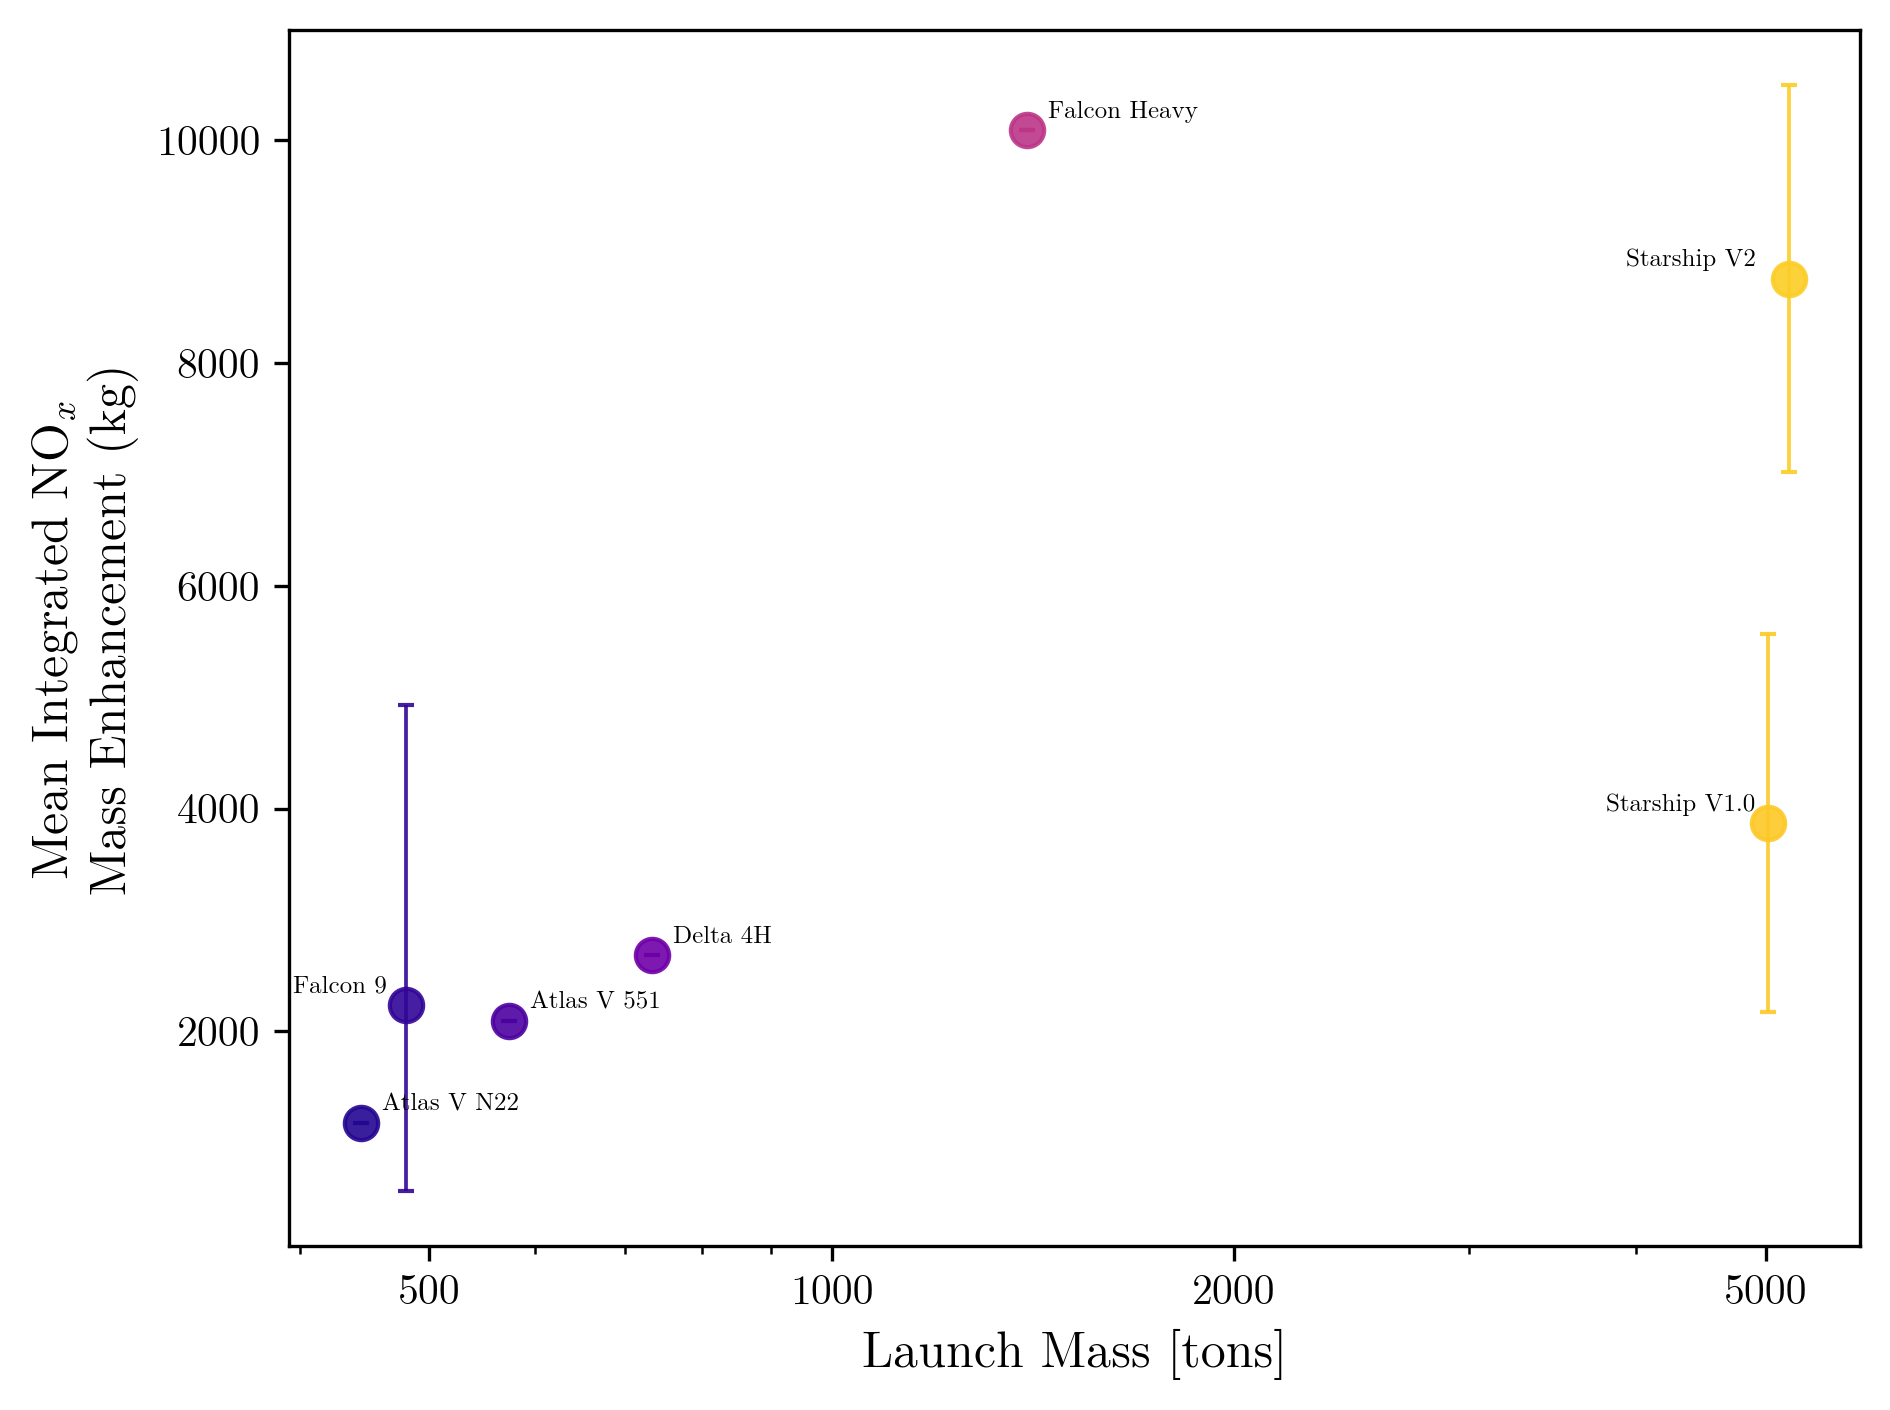

In [11]:
# Same color mapping as the bar plot
cmap = plt.cm.plasma
# norm = plt.Normalize(np.log10(bar_df['ime'].min()),
#                      np.log10(bar_df['ime'].max() + 1000))
log_norm = mpl.colors.LogNorm(
    # vmin=bar_sorted['Launch_Mass'].min(),
    # vmax=bar_sorted['Launch_Mass'].max()+2000
    vmin=400,
    vmax=7000,
    clip=True
)
colors = plt.cm.plasma(log_norm((bar_sorted['Launch_Mass'])))

fig, ax = plt.subplots(dpi=300)

for i, (lv, r) in enumerate(bar_sorted.iterrows()):
    x = r['Launch_Mass']
    y = r['ime']
    yerr = [[y - r['ime_min']], [r['ime_max'] - y]]  # lower, upper deltas

    # c = cmap(log_norm(y))  # color matches bar figure
    c = colors[i]

    ax.errorbar(x, y, yerr=yerr, fmt='o',
                color=c, ecolor=c, elinewidth=0.9, capsize=2,
                markersize=8, alpha=0.9)

ax.set_xscale('log')
ax.set_xlabel('Launch Mass [tons]', fontsize=12)
ax.set_ylabel('Mean Integrated NO$_x$ \n Mass Enhancement (kg)', fontsize=12)
plt.tight_layout()

for lv, r in bar_df.iterrows():
    if lv in ['Falcon 9']:
        ax.annotate(lv, (r['Launch_Mass'], r['ime']), xytext=(-27, 3),
                    textcoords='offset points', fontsize=6, rotation=00)
    elif lv in ['Starship V2', 'Starship V1.0',]:
        ax.annotate(lv, (r['Launch_Mass'], r['ime']), xytext=(-39,3),
                    textcoords='offset points', fontsize=6, rotation=00)
    else:
        ax.annotate(lv, (r['Launch_Mass'], r['ime']), xytext=(5,3),
                    textcoords='offset points', fontsize=6, rotation=00)

ax.xaxis.set_ticks([ 500, 1000, 2000, 5000,])
ax.xaxis.set_ticklabels([ 500, 1000, 2000, 5000])

fig.tight_layout()
# save figure
plt.savefig(f'figures/supfig_6.png', dpi=300)

# ax.set_yscale('log')